<a href="https://colab.research.google.com/github/ol3gka/AI_Masters_NLA_projects_Matrix_Masters/blob/main/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install tntorch
pip install maxvolpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.9 MB/s eta 0:00:00


In [37]:
import torch
torch.set_default_dtype(torch.float64)
import tntorch as tn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# **Сравнение скоростей работы, потребления памяти, точности аппроксимации в зависимости от ранга**

*На двух различных аналитических связях индексов и на матрицах различного размера протестированы следующие алгоритмы:*

1) Каноническое разложение (CP)

2) Разложение Таккера

3) Тензорный поезд (TT)

Были проанализированы скорости работы, точности, выйгрыш по памяти

**Выводы:**

a) Каноническое разложение имеет сложности со сходимостью на рассмотренных аналитических моделях и на всех матрицах

b) Разложение Таккера и ТТ сходятся с рангом апроксимации в два раза меньшим, чем размерности исходных матриц

с) Методы малоранговой аппроксимации способны обеспечить выигрыш в памяти в несколько раз


## Аналитическая связь индексов вида :

$\sqrt{\sqrt{X} \cdot (Y + Z) + Y \cdot Z^2} \cdot (X + \sin(Y) \cdot \cos(Z))$

100%|██████████| 3/3 [02:22<00:00, 47.57s/it]


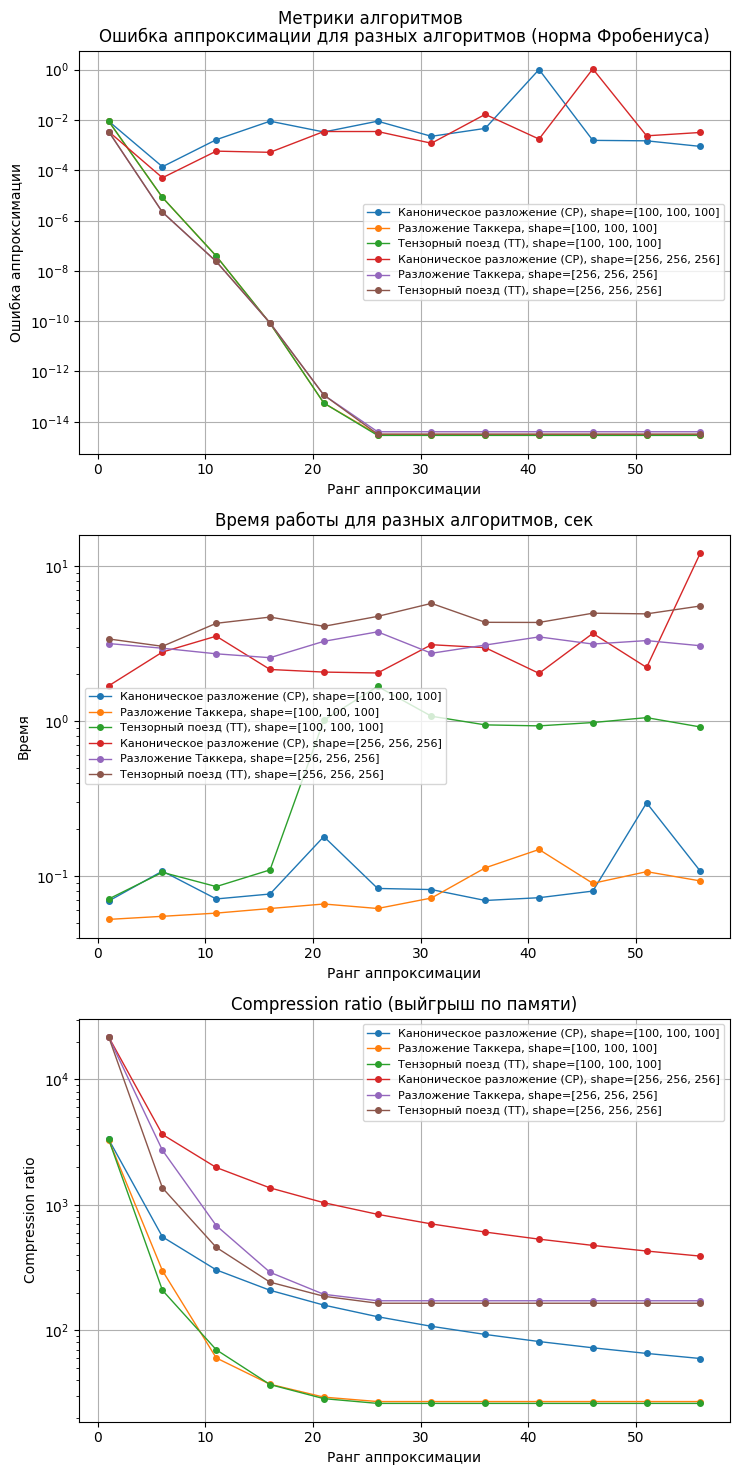

In [ ]:
# plt.rc('font', weight='bold')

shapes = [100, 256] # исследуем алгоритмы на равносторонних тензорах
R = 61 # максимальный ранг аппроксимации

fig, ax = plt.subplots(3, 1, figsize=(3*2.5, 15))
for i, shape in enumerate(shapes):
  # инициализируем матрицы
  X, Y, Z = np.meshgrid(range(shape), range(shape), range(shape))
  # full = torch.Tensor(1. / (X + Y + Z + 1))  # вариант аналитической связь индесов
  full = torch.Tensor(np.sqrt(np.sqrt(X)*(Y+Z) + Y*Z**2)*(X + np.sin(Y)*np.cos(Z)))  # вариант аналитической связь индесов
  # список рангов для малоранговой аппроксимации
  rank_range = np.arange(1, R, 5)
  # БЛОК АЛГОРИТМОВ
  approximation_error = {}
  time_dict = {}
  compression_ratio = {}
  algorithms = ["Каноническое разложение (CP)", "Разложение Таккера", "Тензорный поезд (TT)"]
  for algo in tqdm(algorithms):
    error_array = []
    time_array = []
    compression_array = []
    ranks_cp, ranks_tucker, ranks_tt = None, None, None
    for r in rank_range:
      if algo == "Каноническое разложение (CP)":
        ranks_cp = r
      elif algo == "Разложение Таккера":
        ranks_tucker = r
      elif algo == "Тензорный поезд (TT)":
        ranks_tt = r
      start = time.time()
      t  = tn.Tensor(full, ranks_cp=ranks_cp, ranks_tucker=ranks_tucker, ranks_tt=ranks_tt, verbose=False, tol=1e-5, max_iter=100)
      end = time.time()
      error_array.append(torch.norm(t.torch() - full).item() / torch.norm(full).item())
      time_array.append(end - start)
      compression_array.append(full.numel() / t.numcoef())
    approximation_error[algo] = error_array
    time_dict[algo] = time_array
    compression_ratio[algo] = compression_array
    # print('Compression ratio: {}/{} = {:g}'.format(full.numel(), t.numel(), full.numel() / t.numel()))
    # t.numel: Returns the total number of elements in the input tensor.

  # БЛОК РИСОВАНИЯ
  fig.suptitle("Метрики алгоритмов")
  ax[0].set_title("Ошибка аппроксимации для разных алгоритмов (норма Фробениуса)")
  for algo, _error in approximation_error.items():
    ax[0].plot(rank_range, _error, label=f"{algo}, shape=[{shape}, {shape}, {shape}]", marker='o', markersize=4, linestyle='-', linewidth=1)
  ax[0].set_yscale('log')
  ax[0].set_xlabel("Ранг аппроксимации")
  ax[0].set_ylabel("Ошибка аппроксимации")
  ax[0].legend(loc='best', fontsize=8)
  ax[0].grid(True, axis='both')

  ax[1].set_title("Время работы для разных алгоритмов, сек")
  for algo, _time in time_dict.items():
    ax[1].plot(rank_range, _time, label=f"{algo}, shape=[{shape}, {shape}, {shape}]", marker='o', markersize=4, linestyle='-', linewidth=1)
  ax[1].set_yscale('log')
  ax[1].set_xlabel("Ранг аппроксимации")
  ax[1].set_ylabel("Время")
  ax[1].legend(loc='best', fontsize=8)
  ax[1].grid(True, axis='both')

  ax[2].set_title("Compression ratio (выйгрыш по памяти)")
  for algo, _c_ratio in compression_ratio.items():
    ax[2].plot(rank_range, _c_ratio, label=f"{algo}, shape=[{shape}, {shape}, {shape}]", marker='o', markersize=4, linestyle='-', linewidth=1)
  ax[2].set_yscale('log')
  ax[2].set_xlabel("Ранг аппроксимации")
  ax[2].set_ylabel("Compression ratio")
  ax[2].legend(loc='best', fontsize=8)
  ax[2].grid(True, axis='both')


fig.tight_layout()
plt.show()
fig.savefig('full_figure_1.png')

## Аналитическая связь индесов вида: $ \frac{1}{X + Y + Z + 1}$

100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


100%|██████████| 3/3 [00:25<00:00,  8.47s/it]


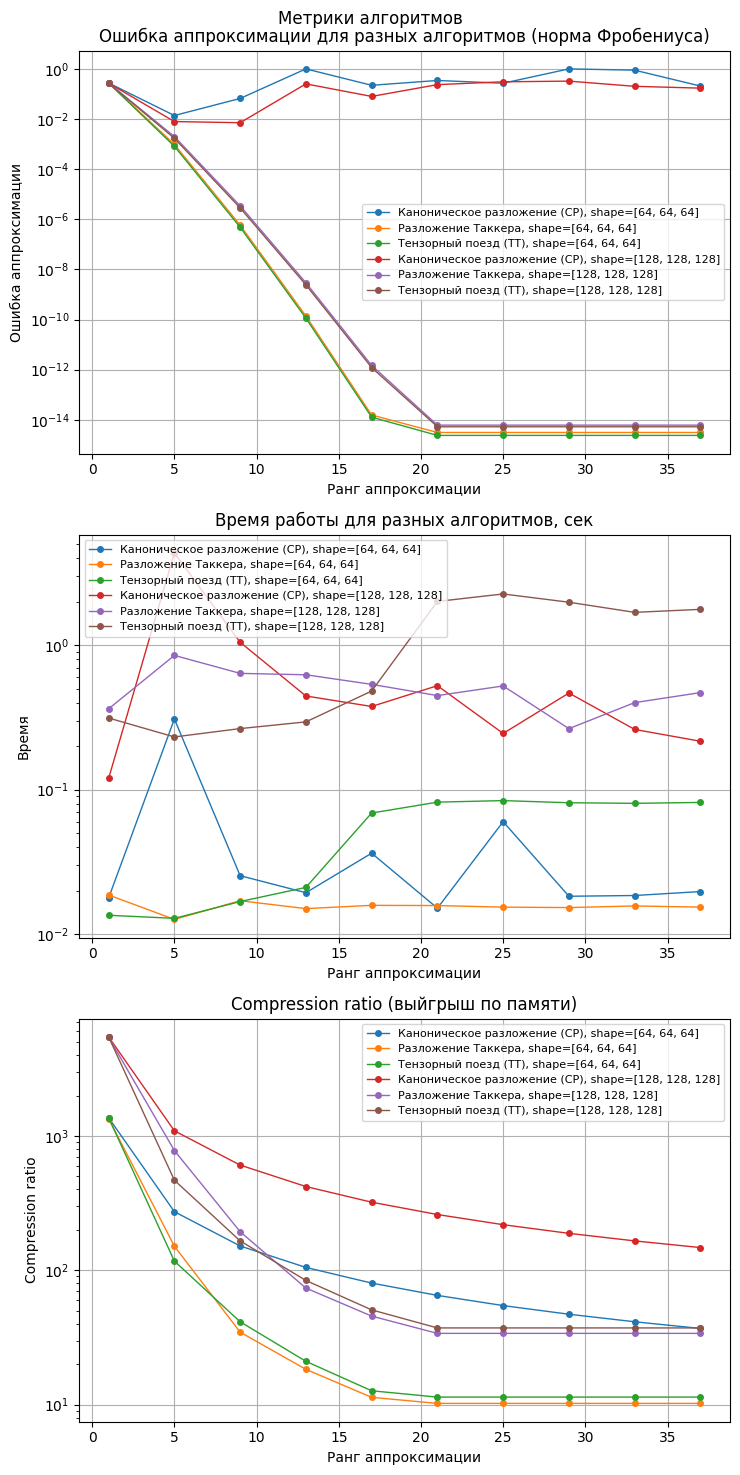

In [ ]:
shapes = [64, 128] # исследуем алгоритмы на равносторонних тензорах
R = 40 # максимальный ранг аппроксимации

fig, ax = plt.subplots(3, 1, figsize=(3*2.5, 15))
for i, shape in enumerate(shapes):
  # инициализируем матрицы
  X, Y, Z = np.meshgrid(range(shape), range(shape), range(shape))
  full = torch.Tensor(1. / (X + Y + Z + 1))  # вариант аналитической связь индесов
  # full = torch.Tensor(np.sqrt(np.sqrt(X)*(Y+Z) + Y*Z**2)*(X + np.sin(Y)*np.cos(Z)))  # вариант аналитической связь индесов
  # список рангов для малоранговой аппроксимации
  rank_range = np.arange(1, R, 4)

  # БЛОК АЛГОРИТМОВ
  approximation_error = {}
  time_dict = {}
  compression_ratio = {}
  algorithms = ["Каноническое разложение (CP)", "Разложение Таккера", "Тензорный поезд (TT)"]

  for algo in tqdm(algorithms):
    error_array = []
    time_array = []
    compression_array = []
    ranks_cp, ranks_tucker, ranks_tt = None, None, None
    for r in rank_range:
      if algo == "Каноническое разложение (CP)":
        ranks_cp = r
      elif algo == "Разложение Таккера":
        ranks_tucker = r
      elif algo == "Тензорный поезд (TT)":
        ranks_tt = r
      start = time.time()
      t  = tn.Tensor(full, ranks_cp=ranks_cp, ranks_tucker=ranks_tucker, ranks_tt=ranks_tt, verbose=False, tol=1e-5, max_iter=100)
      end = time.time()
      error_array.append(torch.norm(t.torch() - full).item() / torch.norm(full).item())
      time_array.append(end - start)
      compression_array.append(full.numel() / t.numcoef())
    approximation_error[algo] = error_array
    time_dict[algo] = time_array
    compression_ratio[algo] = compression_array
    # print('Compression ratio: {}/{} = {:g}'.format(full.numel(), t.numel(), full.numel() / t.numel()))
    # t.numel: Returns the total number of elements in the input tensor.

  # БЛОК РИСОВАНИЯ
  print()
  fig.suptitle("Метрики алгоритмов")
  ax[0].set_title("Ошибка аппроксимации для разных алгоритмов (норма Фробениуса)")
  for algo, _error in approximation_error.items():
    ax[0].plot(rank_range, _error, label=f"{algo}, shape=[{shape}, {shape}, {shape}]", marker='o', markersize=4, linestyle='-', linewidth=1)
  ax[0].set_yscale('log')
  ax[0].set_xlabel("Ранг аппроксимации")
  ax[0].set_ylabel("Ошибка аппроксимации")
  ax[0].legend(loc='best', fontsize=8)
  ax[0].grid(True, axis='both')

  ax[1].set_title("Время работы для разных алгоритмов, сек")
  for algo, _time in time_dict.items():
    ax[1].plot(rank_range, _time, label=f"{algo}, shape=[{shape}, {shape}, {shape}]", marker='o', markersize=4, linestyle='-', linewidth=1)
  ax[1].set_yscale('log')
  ax[1].set_xlabel("Ранг аппроксимации")
  ax[1].set_ylabel("Время")
  ax[1].legend(loc='best', fontsize=8)
  ax[1].grid(True, axis='both')

  ax[2].set_title("Compression ratio (выйгрыш по памяти)")
  for algo, _c_ratio in compression_ratio.items():
    ax[2].plot(rank_range, _c_ratio, label=f"{algo}, shape=[{shape}, {shape}, {shape}]", marker='o', markersize=4, linestyle='-', linewidth=1)
  ax[2].set_yscale('log')
  ax[2].set_xlabel("Ранг аппроксимации")
  ax[2].set_ylabel("Compression ratio")
  ax[2].legend(loc='best', fontsize=8)
  ax[2].grid(True, axis='both')


fig.tight_layout()
plt.show()
fig.savefig('full_figure_2.png')

In [ ]:
t

3D TT tensor:

 128 128 128
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   20  20  1

**Переменный метод наименьших квадратов**

In [ ]:
pip install tensorly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
import torch
import scipy.linalg as scp
from tensorly import unfold
import numpy as np

In [ ]:
tensor=np.random.rand(5,3,2)

In [ ]:
def Least_squares_variables_decompose(tensor, rank, max_iter=1000000, tol=1e-5):
    U = np.random.random((rank, tensor.shape[0]))
    V = np.random.random((rank, tensor.shape[1]))
    W = np.random.random((rank, tensor.shape[2]))
    epoch=0
    loss=100
    while ((epoch<=max_iter)*(loss>=tol)):
        U0 = scp.khatri_rao(V.T, W.T)
        U1 = unfold(tensor, mode=0).T
        U = np.linalg.solve(U0.T @ U0, U0.T @ U1) #оптимизируем по U
        V0 = scp.khatri_rao(U.T, W.T)
        V1 = unfold(tensor, mode=1).T
        V = np.linalg.solve(V0.T @ V0, V0.T @ V1) #оптимизируем по V
        W0 = scp.khatri_rao(U.T, V.T)
        W1 = unfold(tensor, mode=2).T
        W = np.linalg.solve(W0.T @ W0, W0.T @ W1)
        loss = np.linalg.norm(W0 @ W - W1, ord='fro')
        epoch+=1
    print("Epoch:", epoch, " Loss:", loss)

    return U.T, V.T, W.T

In [ ]:
Least_squares_variables_decompose(tensor, rank=5)

Epoch: 6540  Loss: 9.99776101245391e-06


(array([[-2.67674163,  2.72302807,  5.46288066,  2.63605522, -3.29520307],
        [ 2.5551377 , -3.32081512,  0.26235333, -0.62581448,  2.89482681],
        [ 1.64794317, -3.55915724,  2.91368551, -1.29587692,  2.14531561],
        [ 1.55153906, -3.44108628, -2.46450238,  1.44111164,  0.6272281 ],
        [-0.0575291 ,  3.75640045,  4.35246406,  0.95126846,  0.28507843]]),
 array([[ 1.13770804,  0.27289261,  0.17879565,  0.35033531,  1.11737622],
        [ 0.38793245, -0.05646413,  0.22109676,  0.33272554,  0.45798791],
        [ 0.56718874,  0.42373101,  0.10544184,  0.44668845,  0.57597662]]),
 array([[ 0.69174895,  0.27432049,  0.91873512,  0.27586068, -0.25975568],
        [-0.28861249, -0.16768383,  0.46708888,  0.91906417,  0.47779513]]))

# **Тензорный поезд (ТТ)**

Как достижения мультилинейной алгебры помогают преодолеть проклятие размерности?

<div>
<img src="https://raw.githubusercontent.com/ol3gka/AI_Masters_NLA_projects_Matrix_Masters/main/pictures/TT1.png" width="600"/>
</div>

 Источник картинки: iclcollective.com




 <div>
<img src="https://raw.githubusercontent.com/ol3gka/AI_Masters_NLA_projects_Matrix_Masters/main/pictures/tt3.png" width="600"/>
</div>

<div>
<img src="https://raw.githubusercontent.com/ol3gka/AI_Masters_NLA_projects_Matrix_Masters/main/pictures/tt2.png" width="600"/>
</div>




*Tensor-Train Decomposition, 2011, I. V. Oseledets*

**Ключевые особенности:**

a) не игнорирует аналитическую связь между компонентами тензора и их индексами

b) в среднем, хорошая сходимость, устойчивость

c) *O(tnd)* по памяти

d) в большинстве случаев дает наименьший возможный TT-rank

e) развитая тензорная алгебра (умножение, сложение)

**Сложности:**

a) представление не единственно

b) алгоритм может привести к разным рангам результирующего тензора

c) быстрый рост рангов ядер в случае, если размер множества образов, которым обладают производящие функции, слишком велик


**Область применения:**

Решение многомерных параболических уравнений в частных производных

Лучше всего работает (по сравнению с другими методами):

a) разреженные матрицы

b) матрицы, которые имеют небольшое количество возможных значений


In [ ]:
def TTSVD_3d(A: np.ndarray, r:list, svd=np.linalg.svd):
    '''
    Функция вычисляет разложение методом тензорного поезда в случае трехмерного массива

    :param A: np.ndarray размера n1 x n2 x n3 - исходный тензор
    :param r: list [r1, r2] с модами размерностей ядра G (если int, то все моды одинаковые)
    :param svd: func - способ вычисления SVD разверток

    :return G1, G2, G3: np.ndarrays -  факторы разложения ТТ
    '''
    N1,N2,N3 = A.shape
    r1, r2 = r
    A1=A.reshape(N1, N2*N3)
    U, s, V = svd(A1)
    G1 = U[:,:r1] #N1 x r1
    V1 = np.diag(s[:r1]) @ V[:r1, :] # r1 x N2*N3
    V1 = V1.reshape(r1 * N2, N3)
    U, s, V = svd(V1)
    G2 = U[:,:r2] # r1*N2 x r2
    G2 = G2.reshape(r1, N2, r2) # r1 x N2 x r2
    G3 = np.diag(s[:r2]) @V[:r2,:] # r2 x N3
    return G1, G2, G3

def tt_to_tensor_3d(factors):
    """

    Функция вычисляет изначальный тензор по ТТ

    :param factors: [G1, G2, G3] - факторы ТТ


    :return A: np.ndarray размера n1 x n2 x n3 - исходный тензор
    """

    return np.einsum('il,ljm,mk->ijk',G1,G2,G3)

In [ ]:
def tt_svd(A: np.ndarray, r_max: int, eps = 1e-5, svd=np.linalg.svd):
  d = len(A.shape)
  delta = eps / (d-1)**0.5 * np.linalg.norm(A)
  W = A.copy()
  n = np.array(A.shape,dtype=int)
  n_cum = np.prod(n)
  r = np.zeros(d,dtype=int)
  r[d-1] = 1
  T = []
  for i in range(d-1,0,-1):
    W = W.reshape(n_cum // n[i] //r[i], n[i] * r[i] )
    U, s, V = svd(W)
    r_d = 0
    resid_var = np.sum(s)
    while r_d < n[i]:
      resid_var -= s[r_d]
      if resid_var <= delta ** 2:
        break
      r_d += 1
    r[i-1] = min(r_max, r_d+1)
    T.append(V[:r[i-1],:].reshape((r[i-1], n[i], r[i])))
    n_cum = n_cum * r[i-1] // n[i] // r[i]
    W = U[:,:r[i-1]] @ np.diag(s[:r[i-1]])
  T.append(W.reshape(1, n[0], r[0]))
  return T[::-1]


In [ ]:
def tsqr_tt_svd(A: np.ndarray, r_max: int, eps = 1e-5, svd=np.linalg.svd, qr = np.linalg.qr):
  d = len(A.shape)
  delta = None
  n = np.array(A.shape,dtype=int)
  n_cum = np.prod(n)
  W = A.reshape((n_cum // n[d-1], n[d-1]))
  r = np.zeros(d,dtype=int)
  r[d-1] = 1
  T = []
  for i in range(d-1,0,-1):
    _, R = qr(W)
    W = W.reshape(n_cum // n[i] //r[i], n[i] * r[i] )
    U, s, V = svd(R)
    if delta is None:
      delta = eps / (d-1)**0.5 * np.linalg.norm(s)
    r_d = 0
    resid_var = np.sum(s)
    while r_d < n[i]:
      resid_var -= s[r_d]
      if resid_var <= delta ** 2:
        break
      r_d += 1
    r[i-1] = min(r_max, r_d+1)
    T.append(V[:r[i-1],:].reshape((r[i-1], n[i], r[i])))
    n_cum = n_cum * r[i-1] // n[i] // r[i]
    W = (W @ V[:r[i-1],:].T).reshape(n_cum // n[i-1] // r[i-1],  n[i-1] * r[i-1])
  T.append(W.reshape(1, n[0], r[0]))
  return T[::-1]


In [ ]:
def tt_to_tensor(factors):
    """

    Функция вычисляет изначальный тензор по ТТ

    :param factors: [G1, G2, ..., G_d] - факторы ТТ


    :return A: np.ndarray - исходный тензор
    """
    description = [factors[0], [0,1,2]]
    for i in range(1,len(factors)-1):
      description.append(factors[i])
      description.append([])

    np.einsum(a, [0,1,2], b, [1,0,3], [2,3])
    cur = np.einsum('ljm,mkq->ljk',factors[-2],factors[-1])
    for i in range(len(factors)-2,0,-1):
      cur = np.einsum('ljm,mk->ljk',factors[-2],factors[-1])
    cur = np.einsum('pil,ljm')
    return np.einsum('il,ljm,mk->ijk',G1,G2,G3)

In [ ]:
tensor=np.random.rand(20,20,20)


In [ ]:
%%timeit
tt_svd(tensor, 2, svd = randSVD)

1.22 ms ± 399 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
tsqr_tt_svd(tensor, 2)

1.07 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
full=torch.Tensor(tensor)

In [ ]:
%%timeit

t  = tn.Tensor(tensor, ranks_tt=2, verbose=False, tol=1e-5)

1.41 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
H1, H2, H3 = tsqr_tt_svd(tensor, 9)

np.linalg.norm(tensor - np.einsum('pil,ljm,mkq->ijk',H1, H2, H3))

916 µs ± 182 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
tensor=torch.Tensor(np.random.rand(10,10,10))

In [ ]:
%%timeit
t  = tn.Tensor(tensor, ranks_tt=9, verbose=False, tol=1e-5)

torch.norm(t.torch() - tensor).item() / torch.norm(tensor).item()


1.28 ms ± 52.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
tensor=np.random.rand(10,10,10)

G1, G2, G3 = TTSVD_3d(tensor, r = [2,2])

np.linalg.norm(tt_to_tensor([G1, G2, G3])-tensor)


8.744340557428737

Теперь посмотрим на то, как применяются методы тензорного разложения в кооперативной теории игр. Для этих задач уже есть написанная библиотека.

In [25]:
!rm -rf AI_Masters_NLA_projects_Matrix_Masters

In [26]:
!git clone https://github.com/ol3gka/AI_Masters_NLA_projects_Matrix_Masters

Cloning into 'AI_Masters_NLA_projects_Matrix_Masters'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 372 (delta 19), reused 12 (delta 12), pack-reused 340
Receiving objects: 100% (372/372), 21.52 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (153/153), done.


In [29]:
import AI_Masters_NLA_projects_Matrix_Masters.Project_2.modules.ttgames.ttgames as tg
import tntorch as tn

In [33]:
game = tg.games.Airport(N=10, seed=10)
print(game.ak)

tensor([0.4581, 0.4829, 0.3125, 0.6150, 0.2139, 0.4118, 0.6938, 0.9693, 0.6178,
        0.3304])


In [34]:
t = tn.cross(function=game.function, domain=game.domain(), function_arg='matrix', eps=1e-4)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 10D domain containing 1024 grid points:
iter: 0  | eps: 8.765e-02 | time:   0.4020 | largest rank:   1
iter: 1  | eps: 6.358e-03 | time:   0.8469 | largest rank:   4
iter: 2  | eps: 4.911e-04 | time:   1.2866 | largest rank:   7
iter: 3  | eps: 6.505e-07 | time:   1.6658 | largest rank:  10 <- converged: eps < 0.0001
Did 3354 function evaluations, which took 0.05545s (6.048e+04 evals/s)



In [35]:
tg.semivalues.semivalues(t, ps='shapley')

tensor([0.0539, 0.0589, 0.0323, 0.0919, 0.0214, 0.0462, 0.1308, 0.4064, 0.0928,
        0.0346])

In [44]:
# Airport game
time_tt = {}
for n in (2,4,8,9,10,11,12,13,14,15,16):
    seed = np.random.randint(5,200)
    game = tg.games.Airport(N=n, seed=seed)
    start_time = time.time()
    t = tn.cross(function=game.function, domain=game.domain(), function_arg='matrix', eps=1e-4, verbose=False)
    time_tt[n] = time.time() - start_time
    tg.semivalues.semivalues(t, ps='shapley')

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More

In [45]:
time_tt

{2: 0.016579627990722656,
 4: 0.06811881065368652,
 8: 0.2638113498687744,
 9: 0.49583983421325684,
 10: 0.6468627452850342,
 11: 0.7245893478393555,
 12: 0.7570416927337646,
 13: 1.1061618328094482,
 14: 0.7675912380218506,
 15: 0.9243991374969482,
 16: 2.2055869102478027}

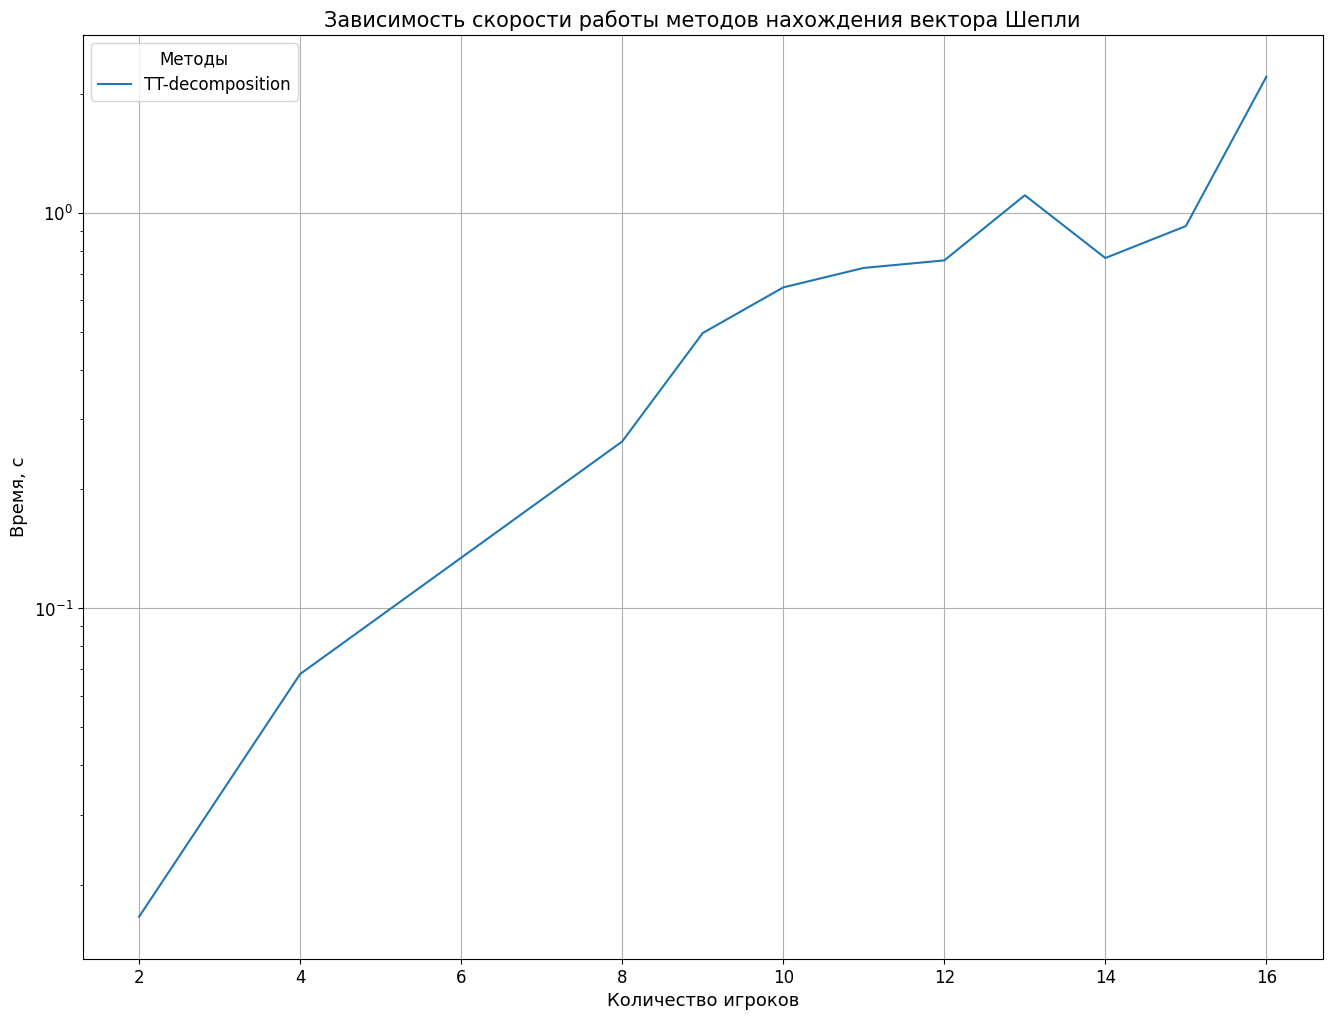

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

ax.semilogy(time_tt.keys(), time_tt.values(), label='TT-decomposition')
ax.set_title('Зависимость скорости работы методов нахождения вектора Шепли', fontsize=15)
ax.set_ylabel('Время, с', fontsize=13)
ax.set_xlabel('Количество игроков', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)
ax.legend(title='Методы', fontsize=12, title_fontsize=12)

# **Разложения в формате Таккера**

In [ ]:
import numpy as np
from sklearn.utils.extmath import randomized_svd
import time
import matplotlib.pyplot as plt

В функции `trueSVD` реализовано стандартное усеченное SVD-разложение.

В функции `randSVD` реализовано довольно новое усеченное рандомизированное SVD-разложение, основанное на теореме Донсона-Линденштрауса.

Пусть дана матрица $A \in \mathbb C^{m \times n}$, будем искать малоранговую аппроксимацию ранга $r - A \approx \tilde A_r$:

1. Генерируем случайную матрицу $\Omega \in \mathbb C^{n \times r},$ где $\Omega_{ij} \sim N(0,1)$;

2. Вычисляем $B=A\Omega \rightarrow O(mnr)$;

3. Делаем $QR$-разложение: $B=QR \rightarrow O(mr^2)$;

4. Вычисялем $SVD$-разложение от $Q^*A=U\Sigma V^* \rightarrow O(mnr+nr^2)$;

5. $\tilde A_r=Q(Q^*A) = (QU)\Sigma V^* = \tilde U \Sigma V^* \rightarrow O(mnr)$.

In [ ]:
def trueSVD(A: np.ndarray, r: int=None) -> np.ndarray:
    '''
    Функция вычисляет усеченное SVD-разложение размера r

    :param A: np.ndarray размера m x n - исходная матрица
    :param r: int размер усеченного разложения

    :return U, s, V: np.ndarrays - компоненты сингулярного разложения
    '''
    if r is None:
        r = min(A.shape)
    U, s, V = np.linalg.svd(A, full_matrices=False)
    return U[:, :r], s[:r], V[:r, :]

def randSVD(A: np.ndarray, r: int=None) -> np.ndarray:
    '''
    Функция вычисляет усеченное рандомизированное SVD-разложение размера r

    :param A: np.ndarray размера m x n - исходная матрица
    :param r: int размер усеченного разложения

    :return U, s, V: np.ndarrays - компоненты рандомизированного сингулярного разложения
    '''
    if r is None:
        r = min(A.shape)
    n = A.shape[1]
    Omega = np.random.normal(size=(n, r))
    B = A @ Omega
    Q, R = np.linalg.qr(B)
    U, s, V = np.linalg.svd(Q.T @ A, full_matrices=False)
    return (Q @ U)[:, :r], s[:r], V[:r, :]

In [ ]:
def HOSVD(T: np.ndarray, r: list) -> np.ndarray:
    '''
    Функция вычисляет разложение Таккера при помощи многомерного SVD (HOSVD)

    :param T: np.ndarray размера n1 x n2 x n3 - исходный тензор
    :param r: list [r1, r2, r3] с модами размерностей ядра G (если int, то все моды одинаковые)

    :return G, U, V, W: np.ndarrays - ядро и факторы разложения Таккера
    '''
    n1, n2, n3 = T.shape
    if isinstance(r, list):
        r1, r2, r3 = r
    else:
        r1, r2, r3 = r, r, r

    T1 = T.reshape(n1, n2*n3) # Ti = T[i,jk] - развертка вдоль направления i
    U1, s1, V1 = trueSVD(T1)
    U = U1[:, :r1]

    T2 = T.transpose([1,0,2]).reshape(n2, n1*n3)
    U2, s2, V2 = trueSVD(T2)
    V = U2[:, :r2]

    T3 = T.transpose([2,0,1]).reshape(n3, n1*n2)
    U3, s3, V3 = trueSVD(T3)
    W = U3[:, :r3]

    WT = ((W.T @ T.transpose([2,0,1]).reshape(n3, n1*n2)).reshape(r3, n1, n2))
    VWT = (V.T @ (WT.transpose([2, 1, 0])).reshape(n2, n1*r3)).reshape(r2, n1, r3)
    G = (U.T @ (VWT.transpose([1, 0, 2])).reshape(n1, r2*r3)).reshape(r1, r2, r3)

    return G.transpose([2,1,0]), U, V, W

In [ ]:
def stHOSVD(T: np.ndarray, r: list, svd=trueSVD) -> np.ndarray:
    '''
    Функция вычисляет разложение Таккера при помощи последовательного многомерного SVD (st-HOSVD)

    :param T: np.ndarray размера n1 x n2 x n3 - исходный тензор
    :param r: list [r1, r2, r3] с модами размерностей ядра G (если int, то все моды одинаковые)
    :param svd: func - способ вычисления SVD разверток

    :return G, U, V, W: np.ndarrays - ядро и факторы разложения Таккера
    '''
    n1, n2, n3 = T.shape
    if isinstance(r, list):
        r1, r2, r3 = r
    else:
        r1, r2, r3 = r, r, r

    T1 = T.reshape(n1, n2*n3) # Ti = T[i,jk] - развертка вдоль направления i
    U1, s1, V1 = svd(T1, r1)
    U = U1 # первый фактор
    T1 = np.diag(s1) @ V1
    T1 = (T1.reshape(r1, n2, n3)).reshape(r1*n2, n3)

    U2, s2, V2 = svd(T1, r3)
    W = V2 # второй фактор
    U2 = U2 @ np.diag(s2)
    U2 = U2.reshape(r1, n2, r3)
    U2 = U2.transpose([1, 0, 2])
    U2 = U2.reshape(n2, r1*r3)

    U3, s3, V3 = svd(U2, r2)
    V = U3 # третий фактор
    G = np.diag(s3) @ V3
    G = G.reshape(r2, r1, r3)
    #order: g@w[k]u[i]v[j]
    return G, U, V, W

Вычисление ошибки разложения:

In [ ]:
def error(T: np.ndarray, G: np.ndarray, U: np.ndarray, V: np.ndarray, W: np.ndarray) -> float:
    '''
    Функция вычисляет относительную ошибку разложения по Фробениусовой норме

    :param T: np.ndarray размера n1 x n2 x n3 - исходный тензор
    :param G, U, V, W: np.ndarrays - ядро и факторы разложения Таккера

    :return error: float - относительная ошибка разложения
    '''
    g1 = G.transpose([1,0,2])
    g11 = g1 @ W
    g2 = g11.transpose([0,2,1])
    g22 = g2 @ V.T
    g3 = g22.transpose([2,1,0])
    g33 = g3 @ U.T
    gg = g33.transpose([2,0,1])
    return np.linalg.norm(T - gg)

# Эксперименты

In [ ]:
def HOSVD_meas(T, r):
    start_time = time.time()
    G, U, V, W = HOSVD(T, r)
    end_time = time.time()
    t = end_time - start_time
    norm = error(T, G.transpose([1,0,2]), U, V, W.T)
    return (t, norm)

def stHOSVD_meas(T, r, svd):
    start_time = time.time()
    G, U, V, W = stHOSVD(T, r, svd)
    end_time = time.time()
    t = end_time - start_time
    norm = error(T, G, U, V, W)
    return (t, norm)

In [ ]:
# sin(i+j+k)
time_hosvd, norm_hosvd = {}, {}
time_sthosvd_true, norm_sthosvd_true = {}, {}
time_sthosvd_rand, norm_sthosvd_rand = {}, {}
time_sthosvd_skl, norm_sthosvd_skl = {}, {}
r = 2
for n in (64, 128, 200, 256, 400):
    T = np.zeros((n, n, n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                T[i,j,k] = np.sin(i+j+k)
    time_hosvd[n], norm_hosvd[n]= HOSVD_meas(T, r)
    time_sthosvd_true[n], norm_sthosvd_true[n] = stHOSVD_meas(T, r, trueSVD)
    time_sthosvd_rand[n], norm_sthosvd_rand[n] = stHOSVD_meas(T, r, randSVD)
    time_sthosvd_skl[n], norm_sthosvd_skl[n] = stHOSVD_meas(T, r, randomized_svd)

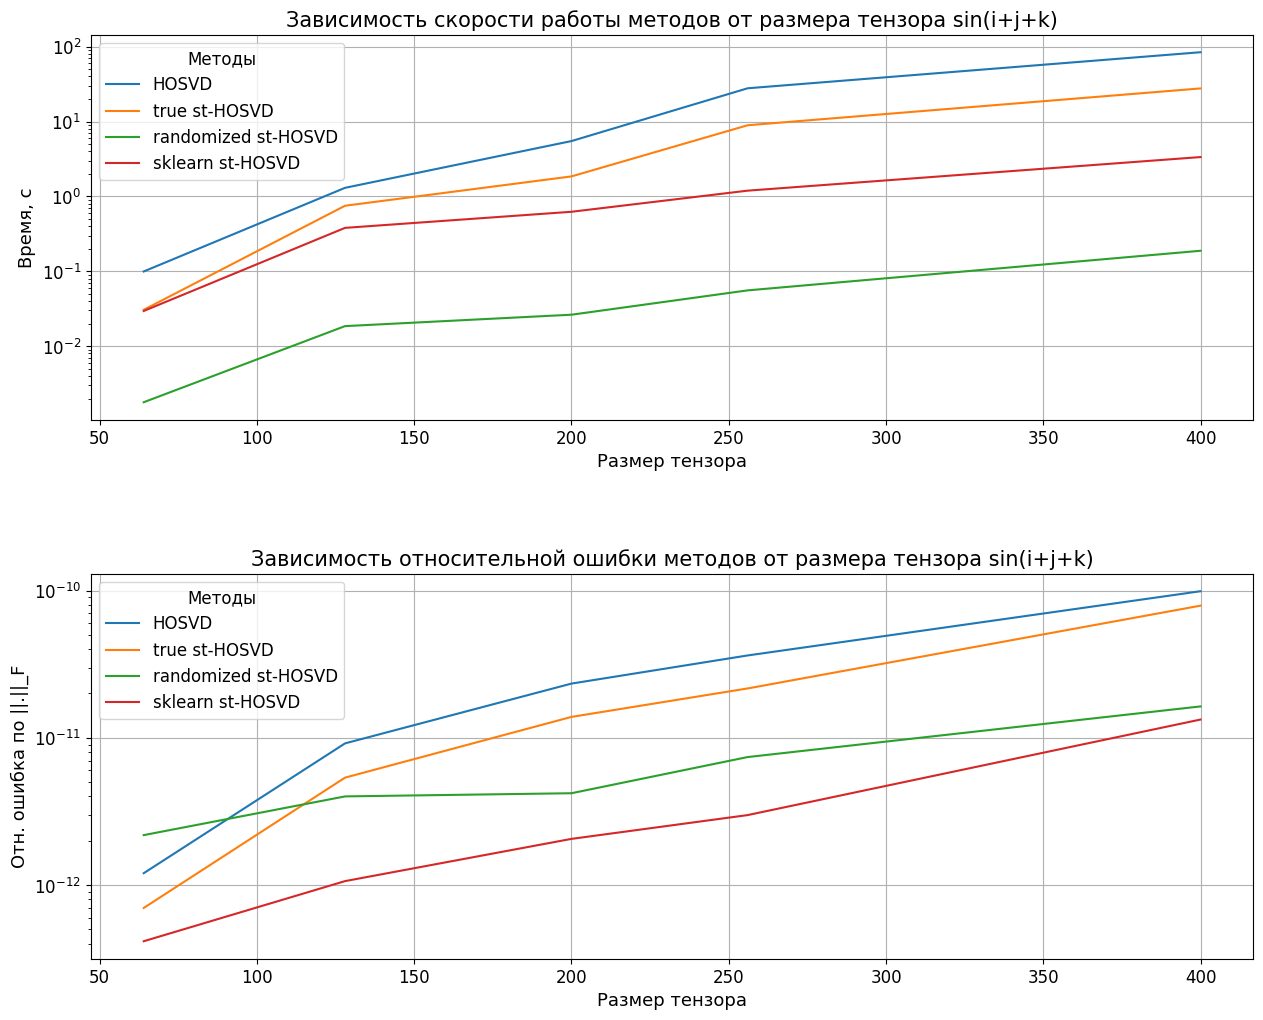

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

ax[0].semilogy(time_hosvd.keys(), time_hosvd.values(), label='HOSVD')
ax[0].semilogy(time_sthosvd_true.keys(), time_sthosvd_true.values(), label='true st-HOSVD')
ax[0].semilogy(time_sthosvd_rand.keys(), time_sthosvd_rand.values(), label='randomized st-HOSVD')
ax[0].semilogy(time_sthosvd_skl.keys(), time_sthosvd_skl.values(), label='sklearn st-HOSVD')
ax[0].set_title('Зависимость скорости работы методов от размера тензора sin(i+j+k)', fontsize=15)
ax[0].set_ylabel('Время, с', fontsize=13)
ax[0].set_xlabel('Размер тензора', fontsize=13)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].grid(True)
ax[0].legend(title='Методы', fontsize=12, title_fontsize=12)

ax[1].semilogy(norm_hosvd.keys(), norm_hosvd.values(), label='HOSVD')
ax[1].semilogy(norm_sthosvd_true.keys(), norm_sthosvd_true.values(), label='true st-HOSVD')
ax[1].semilogy(norm_sthosvd_rand.keys(), norm_sthosvd_rand.values(), label='randomized st-HOSVD')
ax[1].semilogy(norm_sthosvd_skl.keys(), norm_sthosvd_skl.values(), label='sklearn st-HOSVD')
ax[1].set_title('Зависимость относительной ошибки методов от размера тензора sin(i+j+k)', fontsize=15)
ax[1].set_ylabel('Отн. ошибка по ||.||_F', fontsize=13)
ax[1].set_xlabel('Размер тензора', fontsize=13)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].grid(True)
ax[1].legend(title='Методы', fontsize=12, title_fontsize=12)

fig.set_size_inches(15, 12)
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
n = 128
T = np.zeros((n, n, n))
for i in range(n):
    for j in range(n):
        for k in range(n):
            T[i,j,k] = 1/(i+2*j+3*k+2)

In [ ]:
# 1/(i+2j+3k+2)
time_sthosvd_true, norm_sthosvd_true = {}, {}
time_sthosvd_rand, norm_sthosvd_rand = {}, {}
time_sthosvd_skl, norm_sthosvd_skl = {}, {}
for r in range(2, 16):
    time_sthosvd_true[r], norm_sthosvd_true[r] = stHOSVD_meas(T, r, trueSVD)
    time_sthosvd_rand[r], norm_sthosvd_rand[r] = stHOSVD_meas(T, r, randSVD)
    time_sthosvd_skl[r], norm_sthosvd_skl[r] = stHOSVD_meas(T, r, randomized_svd)

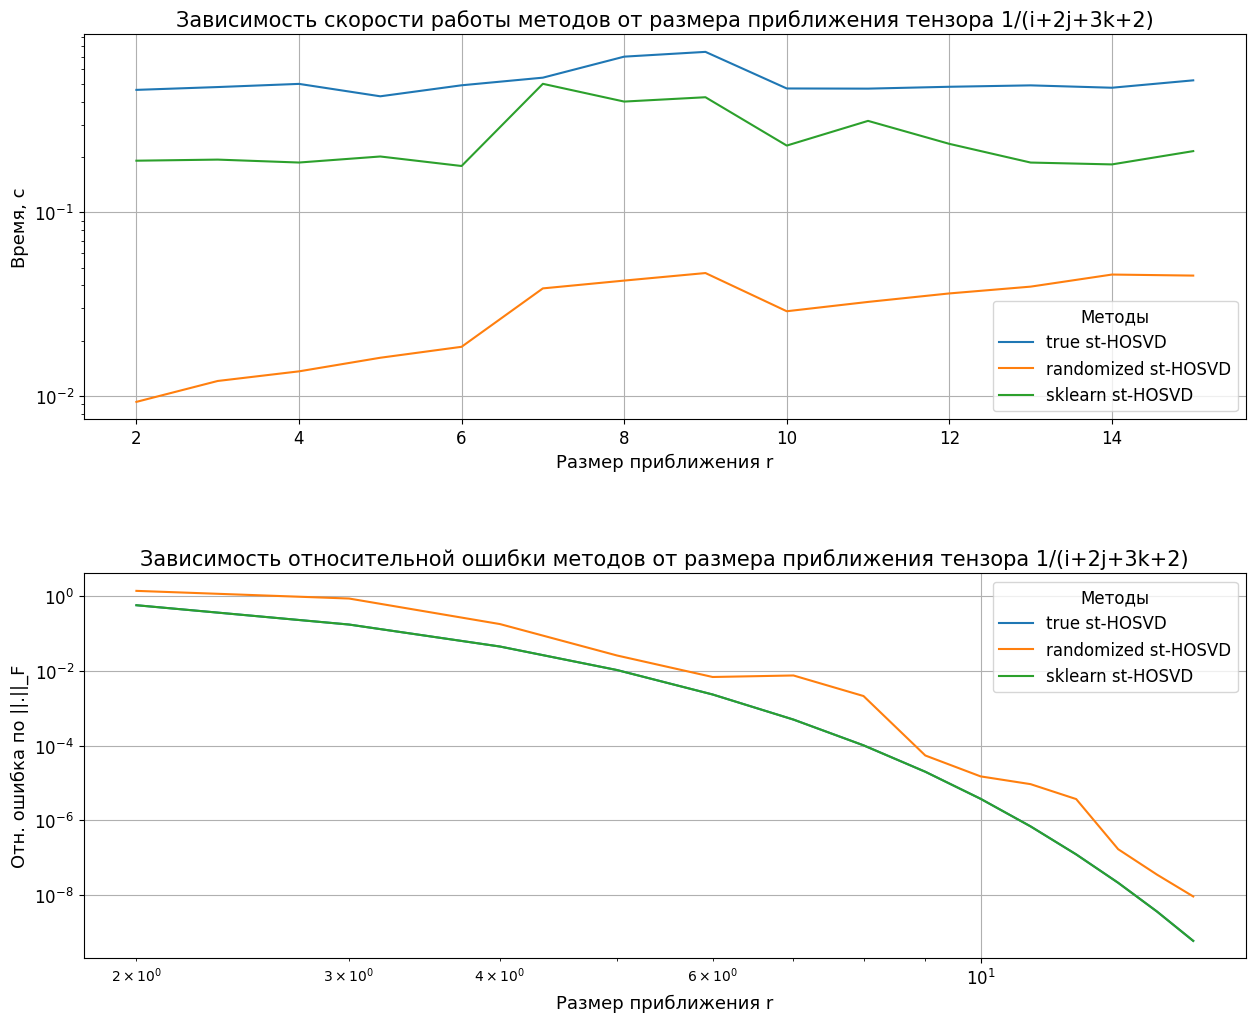

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

ax[0].semilogy(time_sthosvd_true.keys(), time_sthosvd_true.values(), label='true st-HOSVD')
ax[0].semilogy(time_sthosvd_rand.keys(), time_sthosvd_rand.values(), label='randomized st-HOSVD')
ax[0].semilogy(time_sthosvd_skl.keys(), time_sthosvd_skl.values(), label='sklearn st-HOSVD')
ax[0].set_title('Зависимость скорости работы методов от размера приближения тензора 1/(i+2j+3k+2)', fontsize=15)
ax[0].set_ylabel('Время, с', fontsize=13)
ax[0].set_xlabel('Размер приближения r', fontsize=13)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].grid(True)
ax[0].legend(title='Методы', fontsize=12, title_fontsize=12)

ax[1].loglog(norm_sthosvd_true.keys(), norm_sthosvd_true.values(), label='true st-HOSVD')
ax[1].loglog(norm_sthosvd_rand.keys(), norm_sthosvd_rand.values(), label='randomized st-HOSVD')
ax[1].loglog(norm_sthosvd_skl.keys(), norm_sthosvd_skl.values(), label='sklearn st-HOSVD')
ax[1].set_title('Зависимость относительной ошибки методов от размера приближения тензора 1/(i+2j+3k+2)', fontsize=15)
ax[1].set_ylabel('Отн. ошибка по ||.||_F', fontsize=13)
ax[1].set_xlabel('Размер приближения r', fontsize=13)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].grid(True)
ax[1].legend(title='Методы', fontsize=12, title_fontsize=12)

fig.set_size_inches(15, 12)
plt.subplots_adjust(hspace=0.4)
plt.show()